# Constrained FWI Example
We will peform FWI with non-convex constraints using the following steps:
1. Prepare models
2. Setup Constraints with [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl)
3. Build a small local compute cluster (2 workers)
    * Take care of some HPC details related to thread affinity
4. Create source and receivers geometries
5. Build `F`, the JUDI modeling operator
6. Use `F` to create data for both models
7. Visualize data
8. Assess if data is cycle skipped at the farthest offsets
9. Build the `objective` function
10. Perform the FWI using `Spectral Project Gradient` optimization from [SlimOptim](https://github.com/slimgroup/SlimOptim.jl)
11. Visualize velocity models and objective function
12. Visualize data match
14. Remove workers

#### Note on runtime
Warning: this notebook takes around an hour to run for 8 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

## Constrained optimization
For these constrained optimization examples we use software provided by the SLIM group led by Felix Herrmann (previously at University of British Columbia and now at Georgia Tech). 

You must run the previous notebook `10_add_slim_packages.ipynb` to add these packages to your environment if you have not already.

In [1]:
using Distributed, LinearAlgebra, Printf, Random, JOLI, SlimOptim, SetIntersectionProjection, PyPlot

## 1. Prepare models

In [2]:
nz,nx  = 251, 251;
dz,dx  = 15.0, 15.0;
oz,ox  = 0.0, 0.0;
extent = [0, 3750, 3750, 0]

vmin,vmax = 1500,1700
dmin,dmax = -250,+250

(-250, 250)

In [3]:
m0 = vmin * ones(Float32, nz, nx, 1);
m  = vmin * ones(Float32, nz, nx, 1);
m[101:150, 101:150, 1] .= vmax;

### Visualize models

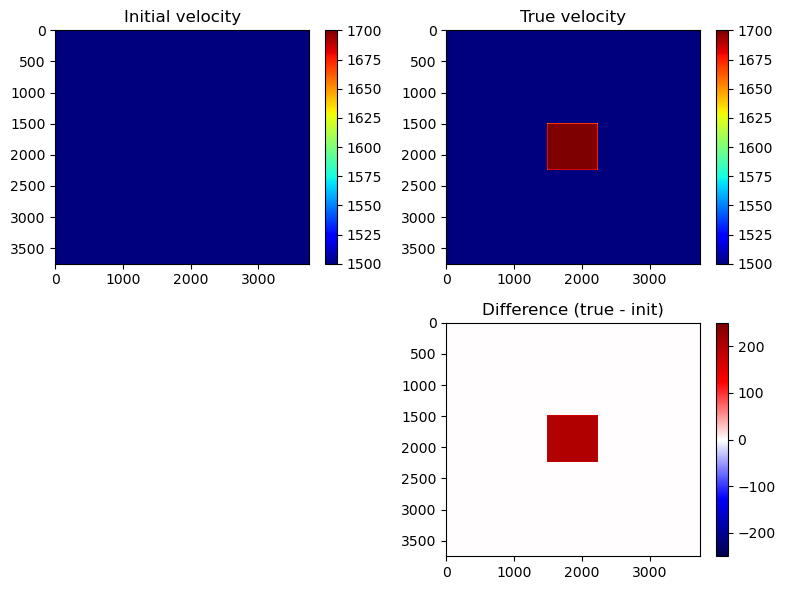

In [4]:
figure(figsize=(8,6))

subplot(2,2,1); imshow(m0,aspect="auto",cmap="jet",extent=extent); colorbar(); clim(vmin,vmax); title("Initial velocity");
subplot(2,2,2); imshow(m,aspect="auto",cmap="jet",extent=extent); colorbar(); clim(vmin,vmax); title("True velocity")
subplot(2,2,4); imshow(m.-m0,aspect="auto",cmap="seismic",extent=extent); colorbar(); clim(dmin,dmax); title("Difference (true - init)");

tight_layout()

## 2. Setup Constraints with [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl)

We setup two constaints:
- Bounds that limit minimum/maximum velocity
- TV, that limits variation and force a piece-wise constant structure

In [5]:
options1 = PARSDMM_options();
options1.FL = Float32;
options1 = default_PARSDMM_options(options1,options1.FL);
options1.adjust_gamma = true
options1.adjust_rho = true
options1.adjust_feasibility_rho = true
options1.Blas_active = true
options1.maxit = 1000
options1.feas_tol = 0.001
options1.obj_tol = 0.001
options1.evol_rel_tol = 0.00001
options1.rho_ini=[1.0f0]
options1.parallel=false
options1.feasibility_only = false
options1.zero_ini_guess=true
constraint1 = Vector{SetIntersectionProjection.set_definitions}(); # bounds only

options2 = PARSDMM_options();
options2.FL = Float32;
options2 = default_PARSDMM_options(options2,options2.FL);
options2.adjust_gamma = true
options2.adjust_rho = true
options2.adjust_feasibility_rho = true
options2.Blas_active = true
options2.maxit = 1000
options2.feas_tol = 0.001
options2.obj_tol = 0.001
options2.rho_ini=[1.0f0]
options2.evol_rel_tol = 0.00001
options2.parallel=false
options2.feasibility_only = false
options2.zero_ini_guess=true

constraint2 = Vector{SetIntersectionProjection.set_definitions}(); # bounds + TV 0.90
options3 = PARSDMM_options();
options3.FL = Float32;
options3 = default_PARSDMM_options(options3,options3.FL);
options3.adjust_gamma = true
options3.adjust_rho = true
options3.adjust_feasibility_rho = true
options3.Blas_active = true
options3.maxit = 1000
options3.feas_tol = 0.001
options3.obj_tol = 0.001
options3.rho_ini=[1.0f0]
options3.evol_rel_tol = 0.00001
options3.parallel=false
options3.feasibility_only = false
options3.zero_ini_guess=true
constraint3 = Vector{SetIntersectionProjection.set_definitions}(); # bounds + TV 1.00

In [6]:
# model definition
struct grid
    n
    d
    o
end
model0 = grid((nz, nx), (dz, dx), (0., 0.))

grid((251, 251), (15.0, 15.0), (0.0, 0.0))

In [7]:
# bounds
m_min = vmin .* ones(Float32, nz, nx, 1)
m_max = vmax .* ones(Float32, nz, nx, 1)
set_type = "bounds"
TD_OP = "identity"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint1, set_definitions(set_type,TD_OP,reshape(m_min,:),reshape(m_max,:),app_mode,custom_TD_OP));
push!(constraint2, set_definitions(set_type,TD_OP,reshape(m_min,:),reshape(m_max,:),app_mode,custom_TD_OP));
push!(constraint3, set_definitions(set_type,TD_OP,reshape(m_min,:),reshape(m_max,:),app_mode,custom_TD_OP));

In [8]:
# TV 0.90
(TV,dummy1,dummy2,dummy3) = get_TD_operator(model0,"TV",options2.FL)
tv2_min = 0.0
tv2_max = norm(TV*reshape(m,:),1) * 0.90
set_type = "l1"
TD_OP = "TV"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint2, set_definitions(set_type,TD_OP,tv2_min,tv2_max,app_mode,custom_TD_OP));

In [9]:
# TV 1.00
(TV,dummy1,dummy2,dummy3) = get_TD_operator(model0,"TV",options3.FL)
tv3_min = 0.0
tv3_max = norm(TV*reshape(m,:),1) * 1.00
set_type = "l1"
TD_OP = "TV"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint3, set_definitions(set_type,TD_OP,tv3_min,tv3_max,app_mode,custom_TD_OP));

In [10]:
# set up no-op projection for L2
function prj0(input)
    x = deepcopy(input)
#     @show "prj0; \n", extrema(input), extrema(x)
    return reshape(x,:)
end

prj0 (generic function with 1 method)

In [11]:
# set up constraints and projection with bounds
(P_sub1,TD_OP1,set_Prop1) = setup_constraints(constraint1,model0,options1.FL)
(TD_OP1,AtA1,l1,y1) = PARSDMM_precompute_distribute(TD_OP1,set_Prop1,model0,options1)
options1.rho_ini = ones(length(TD_OP1))*10.0
proj_intersection1 = x-> PARSDMM(x, AtA1, TD_OP1, set_Prop1, P_sub1, model0, options1)

# Projection function
function prj1(input)
    (x,dummy1,dummy2,dummy3) = proj_intersection1(reshape(input,:))
#     @show "prj1; \n", extrema(input), extrema(x)
    return reshape(x,:)
end

prj1 (generic function with 1 method)

In [12]:
# set up constraints and projection with bounds + TV
(P_sub2,TD_OP2,set_Prop2) = setup_constraints(constraint2,model0,options2.FL)
(TD_OP2,AtA2,l2,y2) = PARSDMM_precompute_distribute(TD_OP2,set_Prop2,model0,options2)
options2.rho_ini = ones(length(TD_OP2))*10.0
proj_intersection2 = x-> PARSDMM(x, AtA2, TD_OP2, set_Prop2, P_sub2, model0, options2)

# Projection function
function prj2(input)
    (x,dummy1,dummy2,dummy3) = proj_intersection2(reshape(input,:))
#     @show "prj2; \n", extrema(input), extrema(x)
    return reshape(x,:)
end

prj2 (generic function with 1 method)

In [13]:
# set up constraints and projection with bounds + TV
(P_sub3,TD_OP3,set_Prop3) = setup_constraints(constraint3,model0,options3.FL)
(TD_OP3,AtA3,l3,y3) = PARSDMM_precompute_distribute(TD_OP3,set_Prop3,model0,options3)
options3.rho_ini = ones(length(TD_OP3))*10.0
proj_intersection3 = x-> PARSDMM(x, AtA3, TD_OP3, set_Prop3, P_sub3, model0, options3)

# Projection function
function prj3(input)
    (x,dummy1,dummy2,dummy3) = proj_intersection3(reshape(input,:))
#     @show "prj3; \n", extrema(input), extrema(x)
    return reshape(x,:)
end

prj3 (generic function with 1 method)

In [14]:
# Test the bounds constraints by applying the projection
# Output should have `min 1500` and `max 1700`

# v1 = vmin - (vmin + vmax) / 2;
# v2 = vmax + (vmin + vmax) / 2;
# m1 = v1 .+ (v2 - v1) .* rand(Float32,nz,nx,1);
# m2 = prj1(m1);
# @show extrema(m1);
# @show extrema(m2);

## 3. Build a small local compute cluster (2 workers)

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [15]:
nthread = Sys.CPU_THREADS
nw = 2

ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread, nw))" 
addprocs(nw)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, div(nthread, nw)
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, div(nthread, nw)) = (0, 21, 22)
(place1, place2, div(nthread, nw)) = (22, 43, 22)


In [16]:
@everywhere using Distributed, DistributedArrays, DistributedJets, FFTW, Jets, JetPack, JetPackDSP, JetPackTransforms
@everywhere using LinearAlgebra, Optim, Printf, Random, WaveFD, JetPackWaveFD
@everywhere using JOLI, SlimOptim, SetIntersectionProjection

      From worker 3:	
      From worker 3:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 3:	  _OPENMP = '201511'
      From worker 3:	  OMP_DYNAMIC = 'FALSE'
      From worker 3:	  OMP_NESTED = 'FALSE'
      From worker 3:	  OMP_NUM_THREADS = '22'
      From worker 3:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 3:	  OMP_PROC_BIND = 'CLOSE'
      From worker 3:	  OMP_PLACES = '{22},{23},{24},{25},{26},{27},{28},{29},{30},{31},{32},{33},{34},{35},{36},{37},{38},{39},{40},{41},{42},{43}'
      From worker 3:	  OMP_STACKSIZE = '0'
      From worker 3:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 3:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 3:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 3:	  OMP_CANCELLATION = 'FALSE'
      From worker 3:	  OMP_DEFAULT_DEVICE = '0'
      From worker 3:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 3:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 3:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From wor

## 4. Create source and receiver geometries
- We use 8 shot locations evenly distributed across the left of the model
- We use 251 receiver locations evenly distributed across the right of the model

In [17]:
@everywhere begin
    ntrec = 1251
    dtrec = 0.004
    dtmod = 0.002
    fpeak = 5.0 
end

In [18]:
nsrc = 8
zsrc = collect(Float32, range(oz, dz * (nz -1), length=nsrc));
xsrc = Float32(dz) .* ones(Float32, nsrc);
print("zsrc; ", zsrc, "\n")
print("xsrc; ", xsrc, "\n")

zsrc; Float32[0.0, 535.7143, 1071.4286, 1607.1428, 2142.8572, 2678.5715, 3214.2856, 3750.0]
xsrc; Float32[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]


In [19]:
nrec = 251
zrec = collect(Float32, range(oz, dz * (nz -1), length=nrec));
xrec = Float32(dz) * (nz - 2) .* ones(Float32, nrec);
print("zrec[1:10]; ", zrec[1:10], "\n")
print("xrec[1:10]; ", xrec[1:10], "\n")

zrec[1:10]; Float32[0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0]
xrec[1:10]; Float32[3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0]


#### Visualize geometry

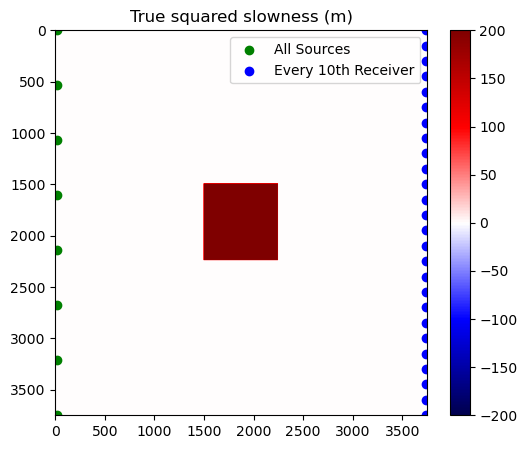

In [20]:
vmin,vmax = extrema(m)
dmin,dmax = -200,+200

figure(figsize=(6,5))
imshow(m .- m0,aspect="auto",cmap="seismic", extent=extent); 
colorbar(); clim(dmin,dmax); title("True squared slowness (m)")
PyPlot.scatter(xsrc, zsrc, c="g", label="All Sources")
PyPlot.scatter(xrec[1:10:end], zrec[1:10:end], c="b", label="Every 10th Receiver")
legend();

## 5. Build `F`, the modeling operator

### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [21]:
@everywhere scratch = "/scratch"
@assert isdir(scratch)

@everywhere function makeF(i::Int,nz::Int,nx::Int,dz::Real,dx::Real,
        zsrc::Array{Float32},xsrc::Array{Float32},zrec::Array{Float32},xrec::Array{Float32})
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,nworkers()),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=fpeak),
        sx = xsrc[i],
        sz = zsrc[i],
        rx = xrec,
        rz = zrec,
        nbz_cache = nz,
        nbx_cache = 16,
        nsponge = 100,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval = 0)
end

In [22]:
F = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,zsrc,xsrc,zrec,xrec) for i in I[1], j in I[2]], (nsrc,1))

"Jet nonlinear operator, (251, 251, 1) → (2512008,)"

## 6. Use `F` to create the data in true and initial models

In [23]:
t1 = @elapsed begin
    d = F * m;
end
@info @sprintf("Time in true model; %.2f seconds\n", t1);

┌ Info: Time in true model; 25.82 seconds
└ @ Main In[23]:4


In [24]:
t2 = @elapsed begin
    d0 = F * m0;
end
@info @sprintf("Time in init model; %.2f seconds\n", t2);

┌ Info: Time in init model; 12.47 seconds
└ @ Main In[24]:4


#### Compute the residual data

In [25]:
r = d0 .- d;

## 7. Visualize data

In [26]:
shots = [1,4,8];

#### Plot shot gathers for true model, initial model, and residual

The table below describes the data images below. We flip the direction of the residual and modeled data in order to help display the match with the true data.

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 1<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True source 1<br>Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 1<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 4<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True source 4<br>Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 4<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 8<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True source 8<br>Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 8<br>Data (flipped)</b></td>
</tr>

</table>

Note that the data modeled in the initial model lacks a lot of reflectivity that is evident in the data modeled in the true model. We expect to recover this missing reflectivity with the FWI.

scale = 28.445922626967565


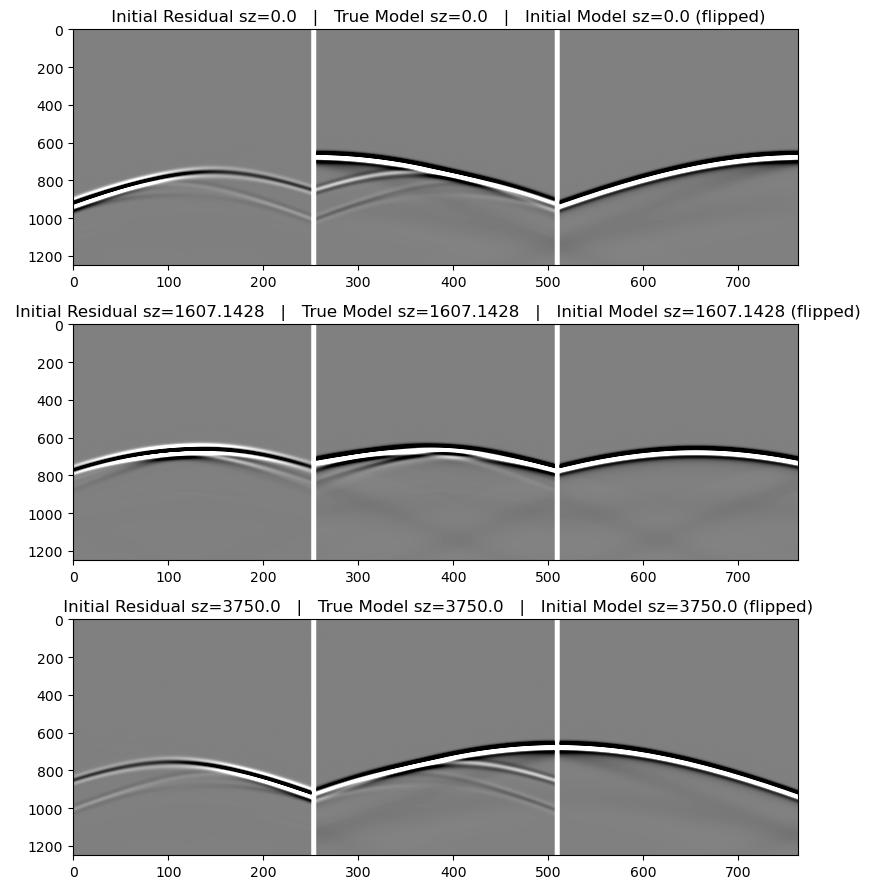

In [27]:
scale = 10.0 / sqrt(norm(d)^2 / length(d))
@show scale

nzero = 5
pad = ones(Float32,ntrec,nzero)

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    d_i  = getblock(d,ishot)
    d0_i = getblock(d0,ishot)
    r_i  = getblock(r,ishot)
    cat2 = hcat(reverse(r_i,dims=2), pad, d_i, pad, reverse(d0_i,dims=2))
    subplot(3,1,iplot);
    imshow(1.5 .* cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sz=$(zsrc[ishot])   |   True Model sz=$(zsrc[ishot])   |   Initial Model sz=$(zsrc[ishot]) (flipped)");
end
tight_layout()

## 8. Assess if data is cycle skipped at the farthest offsets
Next we plot the far offset traces for these three shots in order to assess if the data is cycle skipped. 

You can ovbserve in the plots below that the refraction waveforms (first arrivals) in the initial model are not cycle skipped with respect to the true model, so we can proceed. 

A very significant part of the residual wavefield is actually reflections in this example.

size(t) = (1251,)


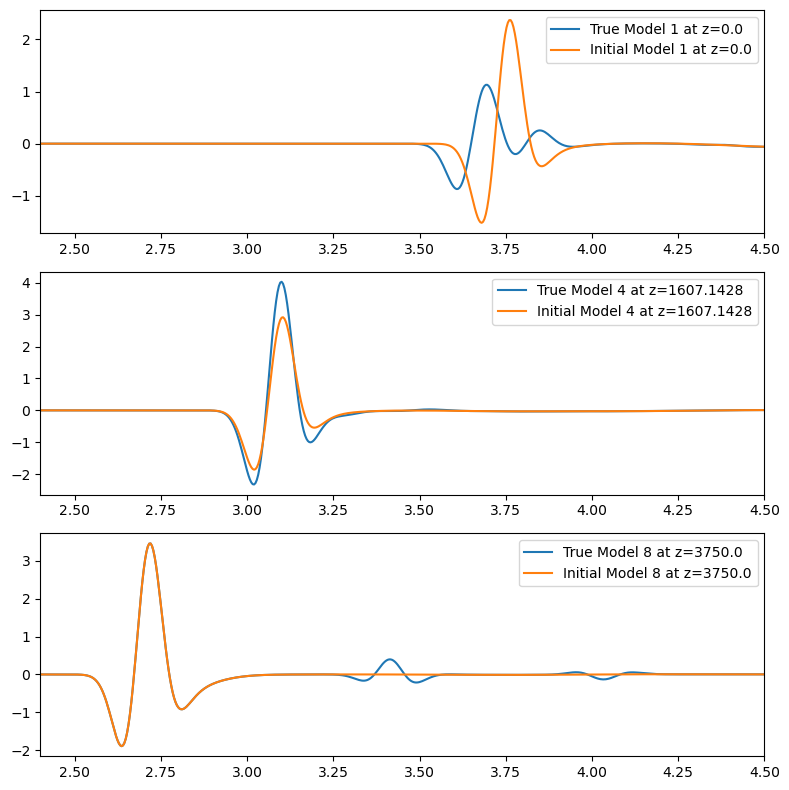

In [28]:
scale = 10.0 / sqrt(norm(d)^2 / length(d))
t = [0.0:dtrec:dtrec*(ntrec - 1);]
@show size(t)

figure(figsize=(8,8)); clf()
for (iplot,ishot) in enumerate(shots)
    subplot(3,1,iplot);
    d_i  = getblock(d,ishot)
    d0_i = getblock(d0,ishot)
    plot(t,d_i[:,end],label="True Model $(ishot) at z=$(zsrc[ishot])");
    plot(t,d0_i[:,end],label="Initial Model $(ishot) at z=$(zsrc[ishot])");
    xlim([2.4,4.5])
    legend()
end
tight_layout()

## 9. Build the `objective` function

#### Build src/rec positions mask
We use this mask to remove the imprint in gradients of proximity to source locations. The mask is set to 0 wherever a source or receiver is close, and is set to 1 otherwise. Without this mask most of the gradient updates would be concentrated close to sources where the model is correct. 

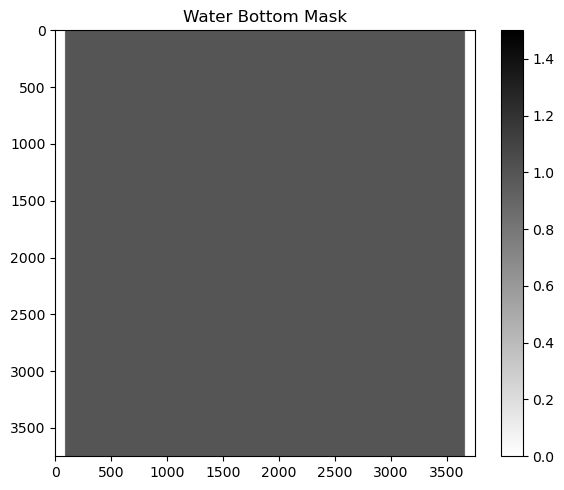

In [29]:
wb_mask = ones(Float32,size(m))
# wb_mask[:, 1:1+5] .= 0;
# wb_mask[:, end-5:end] .= 0;

# figure(figsize=(6,5))
# imshow(wb_mask[:,:,1], aspect="auto",cmap="gray_r",clim=[0,1.5],extent=extent);
# colorbar();
# title("Water Bottom Mask");
# tight_layout()

#### Build the `objective` function
This method is called by the solver whenever the gradient is required. Steps in computing the gradient are as follows:
1. Apply the adjoint of the Jacobian to the current residual `J' * [F*v - d]` 
1. Apply simple scaling based on the size of the first gradient, and save to apply to future gradients

In [30]:
@everywhere α = 0.5

global gscale = 0f0
global fcalls = 0
global gcalls = 0

function objective(F, _G, _m, d, wb_mask)
    m = reshape(_m, domain(F))
    J = jacobian(F,m)

    # illumination compensation
    s1 = srcillum(J)
    srms = sqrt(norm(s1)^2 / length(s1))
    s2 = s1 .+ eps(Float32) * srms
    s3 = s2.^(-α)
    s3 ./= maximum(s3)
    R  = JopDiagonal(reshape(s3, domain(F)))

    # modeling
    dm = zeros(range(F))
    t = @elapsed begin
        dm .= F * m
        global fcalls += 1
    end

    # gradient
    if _G != nothing
        G = reshape(_G, domain(F))
        G .= R ∘ J' * (dm .- d)
        G .*= wb_mask

        global gscale
        if gscale == 0.0
            # compute scalar from first gradient, apply to future gradients
            gscale = 50 ./ maximum(G) 
            @show gscale
        end
        G .*= gscale
        global gcalls += 1
    end

    ϕ = Float32(0.5 * norm(dm .- d)^2)
    
    return ϕ
end

# struct to save the first gradient scalar
global gscale = 0f0
f(x) = objective(F, nothing, x, d, wb_mask);
g!(G, x) = objective(F, G, x, d, wb_mask);
fg!(G, x) = objective(F, G, x, d, wb_mask);

#### Compute gradient

In [31]:
g1 = zeros(domain(F))
tg1 = @elapsed begin
    g!(g1, reshape(m0,:))
    gscale = 0
end
@show tg1;

gscale = 1404.467f0
tg1 = 16.25635612


#### Visualize gradient

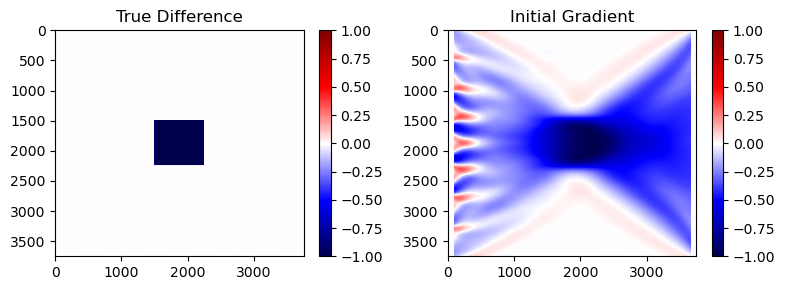

extrema(g1) = (-142.89139f0, 50.0f0)


In [32]:
dm = reshape(m0 .- m,nz,nx)
g1 = reshape(g1,nz,nx)

@show extrema(g1)

figure(figsize=(8,3))

subplot(1,2,1)
imshow(reshape(dm,nz,nx) ./ maximum(abs,dm),aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(-1,1);
title("True Difference");

subplot(1,2,2)
imshow(reshape(g1,nz,nx) ./ maximum(abs,g1),aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(-1,1);
title("Initial Gradient");

tight_layout()

## 10. Perform the FWI using `Spectral Project Gradient` optimization
We will do 10 functions evaluation cost of projected quasi-Newton with four inversion tests:
- Unconstrained
- Bound constraints only
- Bound + TV 0.90 constraints
- Bound + TV 1.00 constraints

In [33]:
# FWI with SPG
niter = 20
options_spg = spg_options(progTol=0, store_trace=true, verbose=3, maxIter=niter)

SlimOptim.SPG_params(3, 1.0f-10, 0, 20, 1.0f-8, 2, true, false, false, true, true, false, true, Inf, 1, 20)

In [34]:
# FWI with SPG -- unconstrained
gscale = 0f0
fcalls = 0
gcalls = 0
mf0  = deepcopy(m0)
sol0 = spg(f, g!, fg!, reshape(mf0,:), prj0, options_spg);
mf0  = reshape(prj1(sol0.x),nz,nx)   # optimal solution
ϕ_0  = sol0.ϕ_trace;                 # cost vs iteration
m_0  = sol0.x_trace;                 # model vs iteration

gscale = 1404.467f0
Running SPG...
Number of objective function to store: 2
Using  spectral projection : true
Maximum number of iterations: 20
SPG optimality tolerance: 1.00e-10
SPG progress tolerance: 0.00e+00
Line search: BackTracking{Float32, Int64}
 Iteration   FunEvals  GradEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     0.00000e+00     1.02054e+05     1.42891e+02
         1          3          2          6     4.99625e-01     1.04975e+00     4.81338e+04     1.09079e+02
         2          4          3          9     1.00000e+00     3.08472e-01     2.31965e+04     8.92990e+01
         3          5          4         12     1.00000e+00     1.86211e-01     6.23047e+03     4.99137e+01
         4          6          5         15     1.00000e+00     1.67035e-01     4.15604e+03     3.33365e+01
         5          7          6         18     1.00000e+00     2.80509e-01     2.70747e+03     2.

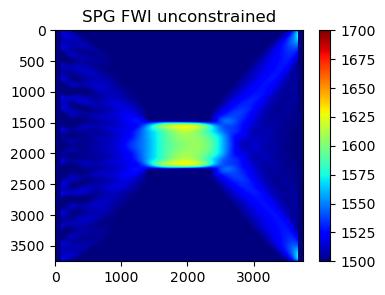

Number of calls to function, gradient;    48    21


PyObject Text(0.5, 1.0, 'SPG FWI unconstrained')

In [35]:
@printf("Number of calls to function, gradient; %5d %5d\n", fcalls, gcalls)
label = @sprintf("SPG FWI unconstrained -- rms %.2f m/s", sqrt(norm(mf0 .- reshape(m,nz,nx))^2 / length(m)))
figure(figsize=(5,4))
imshow(mf0,aspect="auto",cmap="jet",extent=extent); 
colorbar(); clim(vmin,vmax); title("SPG FWI unconstrained")

In [36]:
# FWI with SPG -- bound constrained
gscale = 0f0
fcalls = 0
gcalls = 0
mf1  = deepcopy(m0)
sol1 = spg(f, g!, fg!, reshape(mf1,:), prj1, options_spg);
mf1  = reshape(prj1(sol1.x),nz,nx)   # optimal solution
ϕ_1  = sol1.ϕ_trace;                 # cost vs iteration
m_1  = sol1.x_trace;                 # model vs iteration

input to PARSDMM is feasible, returning
gscale = 1404.467f0
stationary objective and reached feasibility, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
stationary objective and reached feasibility, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
Running SPG...
Number of objective function to store: 2
Using  spectral projection : true
Maximum number of iterations: 20
SPG optimality tolerance: 1.00e-10
SPG progress tolerance: 0.00e+00
Line search: BackTracking{Float32, Int64}
 Iteration   FunEvals  GradEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     0.00000e+00     1.02054e+05     1.42892e+02
stationary objective and reached feasibility, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PA

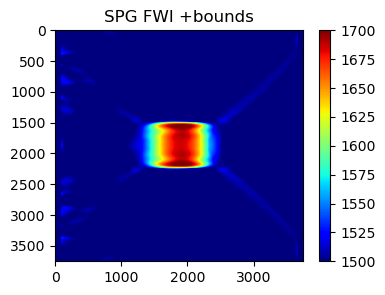

Number of calls to function, gradient;    67    21


PyObject Text(0.5, 1.0, 'SPG FWI +bounds')

In [37]:
@printf("Number of calls to function, gradient; %5d %5d\n", fcalls, gcalls)
label = @sprintf("SPG FWI +bounds -- rms %.2f m/s", sqrt(norm(mf1 .- reshape(m,nz,nx))^2 / length(m)))
figure(figsize=(5,4))
imshow(mf1,aspect="auto",cmap="jet",extent=extent); 
colorbar(); clim(vmin,vmax); title("SPG FWI +bounds")

In [38]:
# FWI with SPG -- bound constrained + TV 0.90
gscale = 0f0
fcalls = 0
gcalls = 0
mf2  = deepcopy(m0)
sol2 = spg(f, g!, fg!, reshape(mf2,:), prj2, options_spg);
mf2  = reshape(prj2(sol2.x),nz,nx)  # optimal solution
ϕ_2  = sol2.ϕ_trace;                # cost vs iteration
m_2  = sol2.x_trace;                # model vs iteration

input to PARSDMM is feasible, returning
gscale = 1404.467f0
relative evolution to small, exiting PARSDMM (iteration 127)
relative evolution to small, exiting PARSDMM (iteration 127)
Running SPG...
Number of objective function to store: 2
Using  spectral projection : true
Maximum number of iterations: 20
SPG optimality tolerance: 1.00e-10
SPG progress tolerance: 0.00e+00
Line search: BackTracking{Float32, Int64}
 Iteration   FunEvals  GradEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     0.00000e+00     1.02054e+05     9.77872e+01
relative evolution to small, exiting PARSDMM (iteration 137)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 45)
         1          3          2          6     4.99505e-01     1.04975e+00     5.39633e+04     6.29478e+01
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PA

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 42)
relative evolution to small, exiting PARSDMM (iteration 18)


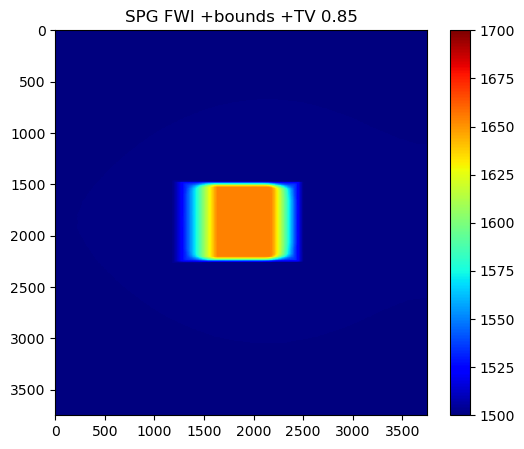

Number of calls to function, gradient;    56    18


PyObject Text(0.5, 1.0, 'SPG FWI +bounds +TV 0.85')

In [39]:
@printf("Number of calls to function, gradient; %5d %5d\n", fcalls, gcalls)
label = @sprintf("SPG FWI +bounds +TV 0.90 -- rms %.2f m/s", sqrt(norm(mf2 .- reshape(m,nz,nx))^2 / length(m)))
figure(figsize=(5,4))
imshow(mf2,aspect="auto",cmap="jet",extent=extent); 
colorbar(); clim(vmin,vmax); title("SPG FWI +bounds +TV 0.90")

In [40]:
# FWI with SPG -- bound constrained + TV 1.00
gscale = 0f0
fcalls = 0
gcalls = 0
mf3  = deepcopy(m0)
sol3 = spg(f, g!, fg!, reshape(mf3,:), prj3, options_spg);
mf3  = reshape(prj2(sol3.x),nz,nx)  # optimal solution
ϕ_3  = sol3.ϕ_trace;                # cost vs iteration
m_3  = sol3.x_trace;                # model vs iteration

input to PARSDMM is feasible, returning
gscale = 1404.467f0
relative evolution to small, exiting PARSDMM (iteration 121)
relative evolution to small, exiting PARSDMM (iteration 121)
Running SPG...
Number of objective function to store: 2
Using  spectral projection : true
Maximum number of iterations: 20
SPG optimality tolerance: 1.00e-10
SPG progress tolerance: 0.00e+00
Line search: BackTracking{Float32, Int64}
 Iteration   FunEvals  GradEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     0.00000e+00     1.02054e+05     1.03600e+02
relative evolution to small, exiting PARSDMM (iteration 129)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 65)
         1          3          2          6     4.99501e-01     1.04975e+00     5.20233e+04     5.77166e+01
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PA

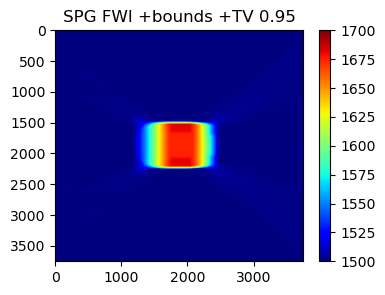

Number of calls to function, gradient;    47    21


PyObject Text(0.5, 1.0, 'SPG FWI +bounds +TV 0.95')

In [41]:
@printf("Number of calls to function, gradient; %5d %5d\n", fcalls, gcalls)
label = @sprintf("SPG FWI +bounds +TV 1.00 -- rms %.2f m/s", sqrt(norm(mf3 .- reshape(m,nz,nx))^2 / length(m)))
figure(figsize=(5,4))
imshow(mf3,aspect="auto",cmap="jet",extent=extent); 
colorbar(); clim(vmin,vmax); title("SPG FWI +bounds +TV 1.00")

## 11. Visualize velocity models and objective function

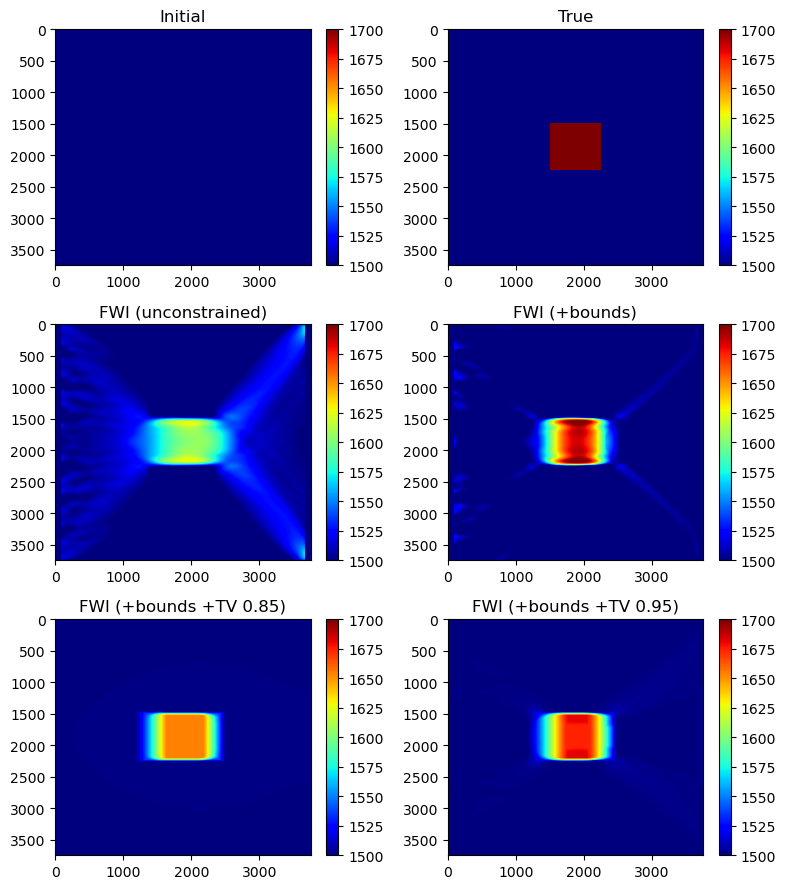

In [42]:
m   = reshape(m,nz,nx)
m0  = reshape(m0,nz,nx)

figure(figsize=(8,9)); clf()

subplot(3,2,1);imshow(m0,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("Initial");

subplot(3,2,2);imshow(m,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("True")

subplot(3,2,3);imshow(mf0,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI (unconstrained)");

subplot(3,2,4);imshow(mf1,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI (+bounds)");

subplot(3,2,5);imshow(mf2,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI (+bounds +TV 0.90)");

subplot(3,2,6);imshow(mf3,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI (+bounds +TV 1.00)");

tight_layout()

#### Display the velocity difference models 

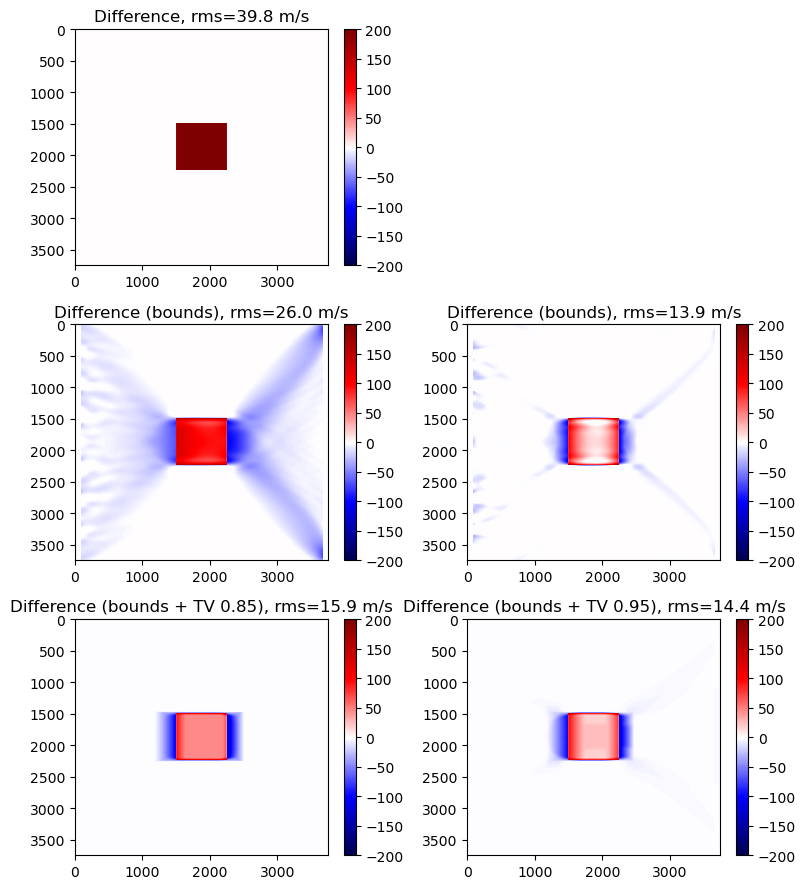

In [43]:
rms_v0  = @sprintf("%.1f m/s", sqrt(norm(m .- m0)^2 / length(m)))

rms_vf0 = @sprintf("%.1f m/s", sqrt(norm(m .- mf0)^2 / length(m)))
rms_vf1 = @sprintf("%.1f m/s", sqrt(norm(m .- mf1)^2 / length(m)))
rms_vf2 = @sprintf("%.1f m/s", sqrt(norm(m .- mf2)^2 / length(m)))
rms_vf3 = @sprintf("%.1f m/s", sqrt(norm(m .- mf3)^2 / length(m)))

figure(figsize=(8,9)); clf()

subplot(3,2,1);imshow(m .- m0,aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(dmin,dmax);
title("Difference, rms=$(rms_v0)");

subplot(3,2,3);imshow(m .- mf0,aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(dmin,dmax);
title("Difference (bounds), rms=$(rms_vf0)");

subplot(3,2,4);imshow(m .- mf1,aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(dmin,dmax);
title("Difference (bounds), rms=$(rms_vf1)");

subplot(3,2,5);imshow(m .- mf2,aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(dmin,dmax);
title("Difference (bounds + TV 0.90), rms=$(rms_vf2)");

subplot(3,2,6);imshow(m .- mf3,aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(dmin,dmax);
title("Difference (bounds + TV 1.00), rms=$(rms_vf3)");

tight_layout()

#### Display the cost function 

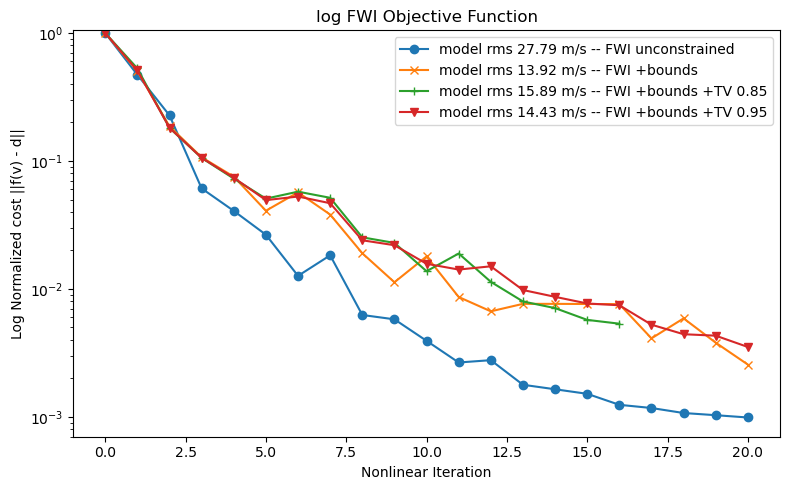

In [55]:
mrmsI = sqrt(norm(reshape(m0,nz,nx) .- m)^2 / length(m))
mrms0 = sqrt(norm(reshape(m_0[end],nz,nx) .- m)^2 / length(m))
mrms1 = sqrt(norm(reshape(m_1[end],nz,nx) .- m)^2 / length(m))
mrms2 = sqrt(norm(reshape(m_2[end],nz,nx) .- m)^2 / length(m))
mrms3 = sqrt(norm(reshape(m_3[end],nz,nx) .- m)^2 / length(m))

figure(figsize=(8,5)); clf()
plot(ϕ_0 ./ ϕ_0[1], marker="o", label=@sprintf("model rms %.2f m/s -- FWI unconstrained", mrms0))
plot(ϕ_1 ./ ϕ_1[1], marker="x", label=@sprintf("model rms %.2f m/s -- FWI +bounds", mrms1))
plot(ϕ_2 ./ ϕ_2[1], marker="+", label=@sprintf("model rms %.2f m/s -- FWI +bounds +TV 0.90", mrms2))
plot(ϕ_3 ./ ϕ_3[1], marker="v", label=@sprintf("model rms %.2f m/s -- FWI +bounds +TV 1.00", mrms3))
yscale("log")
ylim([0,1.05])
xlabel("Nonlinear Iteration")
ylabel("Log Normalized cost ||f(v) - d||")
legend()
title("log FWI Objective Function")
tight_layout()

#### Display data misfit vs model misfit

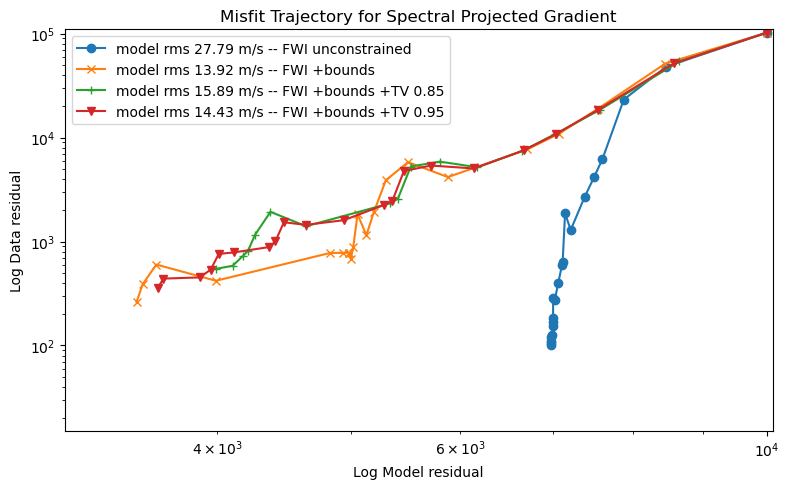

extrema(cat(c0, c1, c2, c3; dims = 1)) = (3495.054f0, 10000.0f0)
extrema(cat(ϕ_0, ϕ_1, ϕ_2, ϕ_3; dims = 1)) = (100.9022f0, 102054.12f0)


In [53]:
figure(figsize=(8,5)); clf()

c0 = [norm(reshape(m_0[i],nz,nx) .- m, 2) for i in 1:length(m_0)]
c1 = [norm(reshape(m_1[i],nz,nx) .- m, 2) for i in 1:length(m_1)]
c2 = [norm(reshape(m_2[i],nz,nx) .- m, 2) for i in 1:length(m_2)]
c3 = [norm(reshape(m_3[i],nz,nx) .- m, 2) for i in 1:length(m_3)]

figure(figsize=(8,5)); clf()
loglog(c0, ϕ_0, marker="o", label=@sprintf("model rms %.2f m/s -- FWI unconstrained", mrms0))
loglog(c1, ϕ_1, marker="x", label=@sprintf("model rms %.2f m/s -- FWI +bounds", mrms1))
loglog(c2, ϕ_2, marker="+", label=@sprintf("model rms %.2f m/s -- FWI +bounds +TV 0.90", mrms2))
loglog(c3, ϕ_3, marker="v", label=@sprintf("model rms %.2f m/s -- FWI +bounds +TV 1.00", mrms3))
@show extrema(cat(c0,c1,c2,c3; dims=1))
@show extrema(cat(ϕ_0,ϕ_1,ϕ_2,ϕ_3; dims=1))
xlim([3100, 10100])
ylim([15, 110000])
legend()
xlabel("Log Model residual")
ylabel("Log Data residual")
title("Misfit Trajectory for Spectral Projected Gradient");
tight_layout()

## 12. Visualize data match
#### Generate data in the FWI velocity model

In [46]:
tf0 = @elapsed begin
    df0 = F * reshape(mf0, domain(F));
end
@show tf0;

tf1 = @elapsed begin
    df1 = F * reshape(mf1, domain(F));
end
@show tf1;

tf2 = @elapsed begin
    df2 = F * reshape(mf2, domain(F));
end
@show tf2;

tf3 = @elapsed begin
    df3 = F * reshape(mf3, domain(F));
end
@show tf3;

tf0 = 14.164397595
tf1 = 14.186564878
tf2 = 14.313533287
tf3 = 14.031206528


#### Compute residuals

In [47]:
r0 = d0 .- d;

rf0 = df0 .- d;
rf1 = df1 .- d;
rf2 = df2 .- d;
rf3 = df3 .- d;

#### Plot shot gathers for true, initial model, and fwi models

The table below describes the data images below. We will flip the direction of the residual and modeled data in order to help display the match with the true data. We include the initial data as shown above for easier comparison. 

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (unconstrained)<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (unconstrained)<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds)<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds)<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds + TV 0.90)<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds + TV 0.90)<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds + TV 1.00)<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds + TV 1.00)<br>Data (flipped)</b></td>
</tr>
</table>

We first make a function to create the plots that we can re-use for the selected shots.

In [48]:
zsrc = trunc.(zsrc; digits=6)

function make_plot(index)
    figure(figsize=(8,15)); clf()
    
    d_i   = getblock(d,index)
    d0_i  = getblock(d0,index)
    r0_i  = getblock(r0,index)

    df0_i = getblock(df0,index)
    df1_i = getblock(df1,index)
    df2_i = getblock(df2,index)
    df3_i = getblock(df3,index)

    rf0_i = getblock(rf0,index)
    rf1_i = getblock(rf1,index)
    rf2_i = getblock(rf2,index)
    rf3_i = getblock(rf3,index)

    cat0  = hcat(reverse(r0_i,dims=2), pad, d_i, pad, reverse(d0_i,dims=2))
    catf0 = hcat(reverse(rf0_i,dims=2), pad, d_i, pad, reverse(df0_i,dims=2))
    catf1 = hcat(reverse(rf1_i,dims=2), pad, d_i, pad, reverse(df1_i,dims=2))
    catf2 = hcat(reverse(rf2_i,dims=2), pad, d_i, pad, reverse(df2_i,dims=2))
    catf3 = hcat(reverse(rf3_i,dims=2), pad, d_i, pad, reverse(df3_i,dims=2))

    subplot(5,1,1);
    imshow(1.5 .* cat0,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial sz=$(zsrc[index])");
    
    subplot(5,1,2);
    imshow(1.5 .* catf1,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" FWI (unconstrained) sz=$(zsrc[index])");
    
    subplot(5,1,3);
    imshow(1.5 .* catf1,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" FWI (+bounds) sz=$(zsrc[index])");
    
    subplot(5,1,4);
    imshow(1.5 .* catf2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("FWI (+bounds +TV 0.90) sz=$(zsrc[index])");

    subplot(5,1,5);
    imshow(1.5 .* catf3,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("FWI (+bounds +TV 1.00) sz=$(zsrc[index])");

    suptitle("Residual | True | Modeled (flipped)\n")
    
    tight_layout()
end

make_plot (generic function with 1 method)

#### Data for the 1st shot, generated in the initial and FWI models

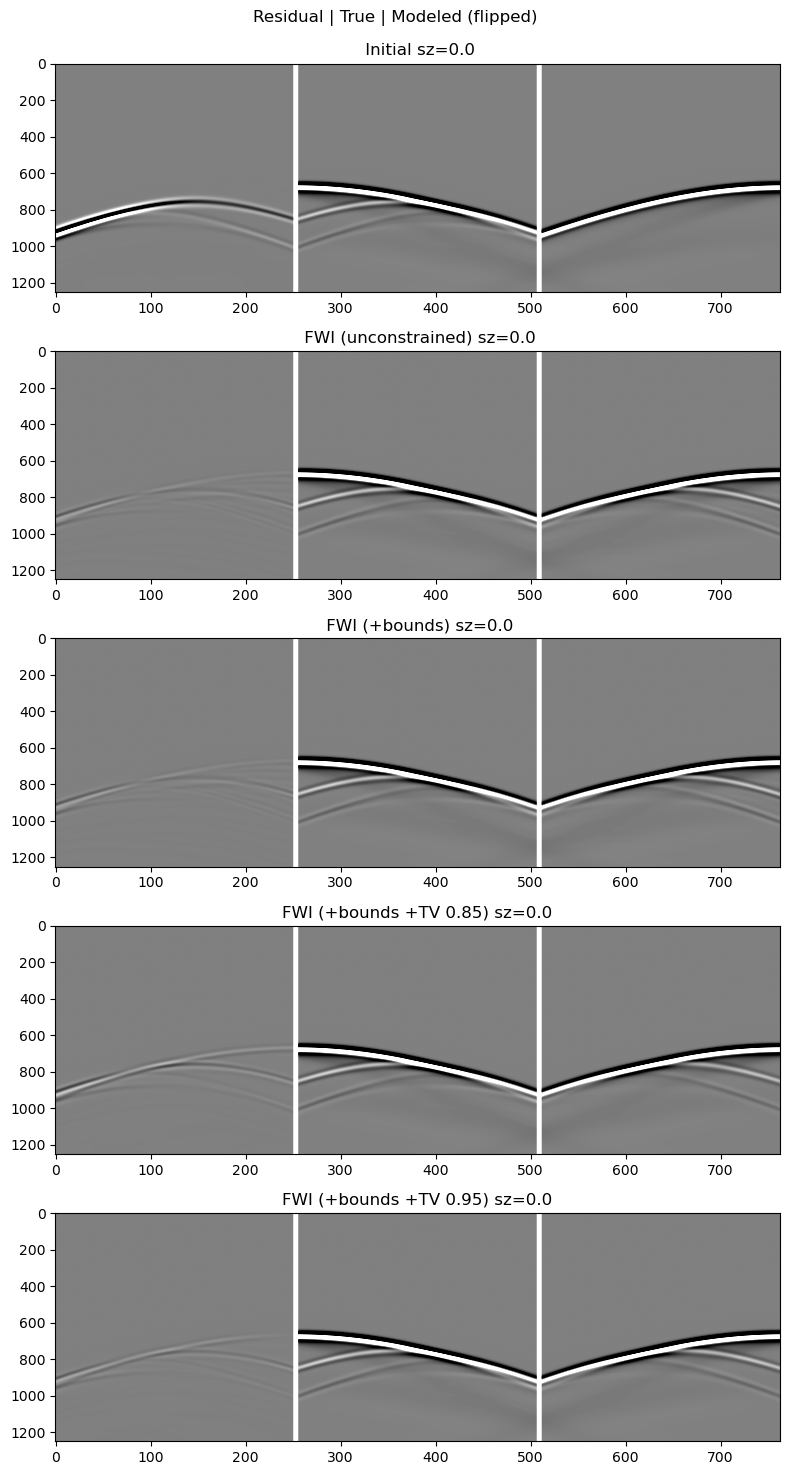

In [49]:
make_plot(1)

#### Data for the 4th shot, generated in the initial and FWI models

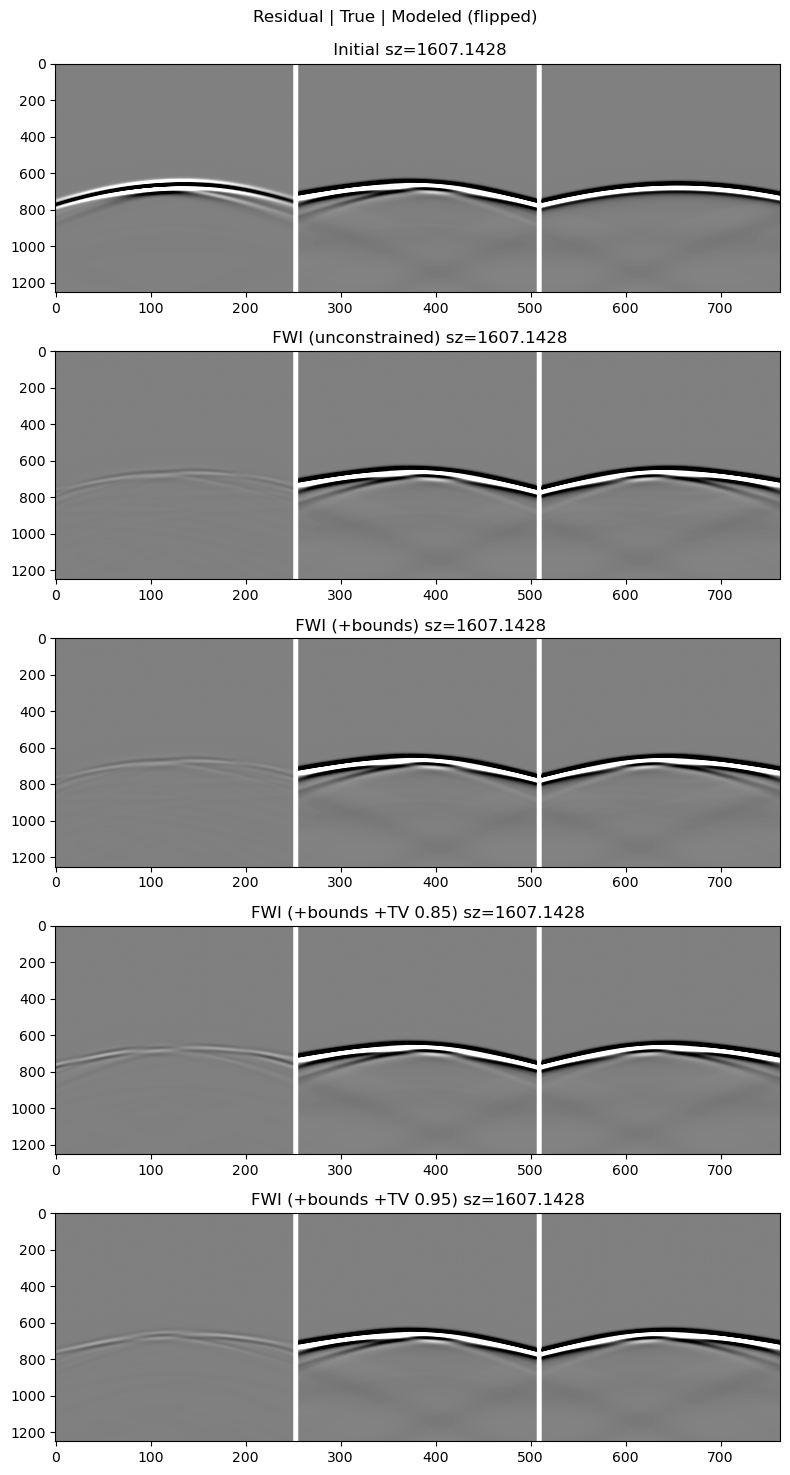

In [50]:
make_plot(4)

#### Data for the 8th shot, generated in the initial and FWI models

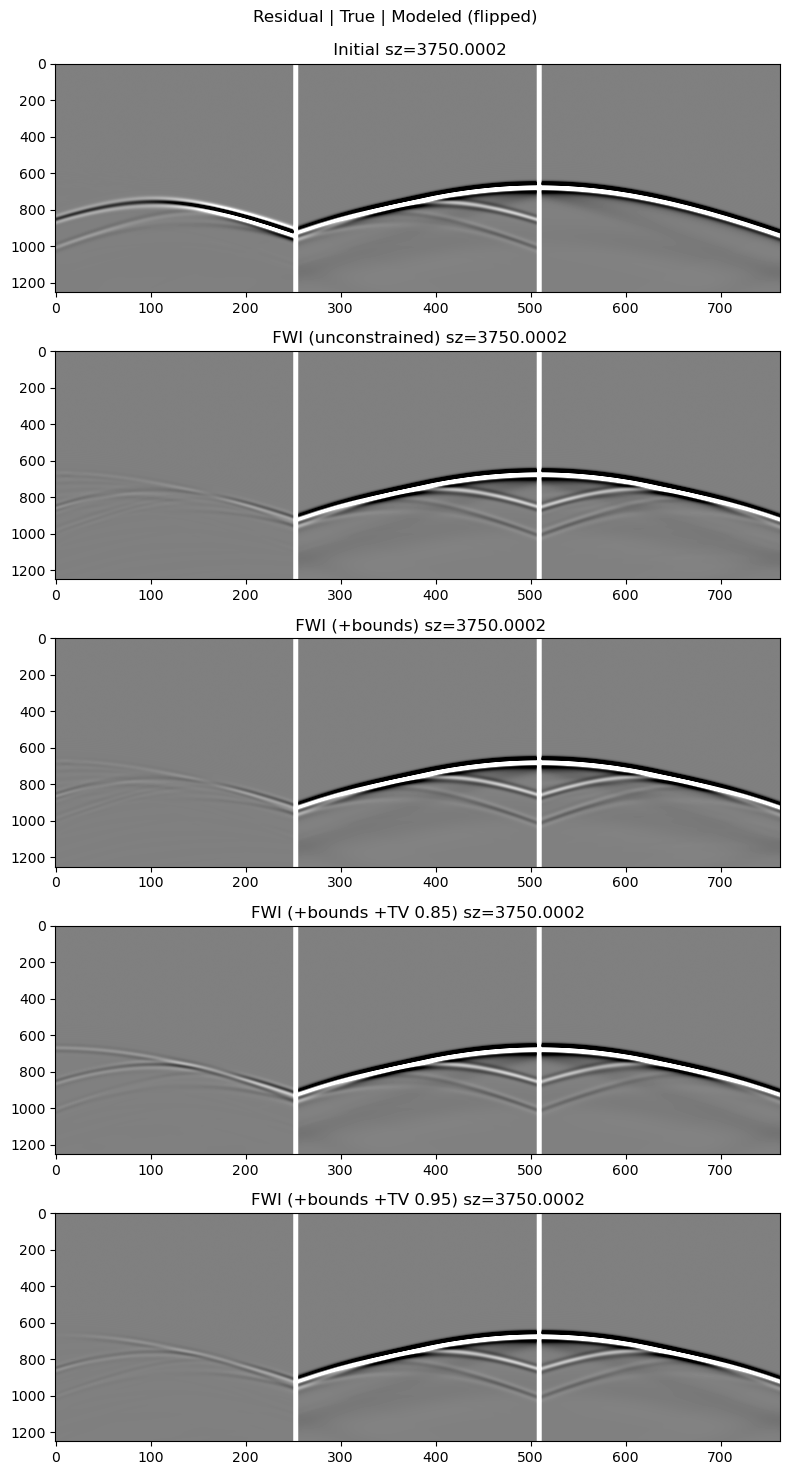

In [51]:
make_plot(8)

## 14. Remove workers <a id='del'></a>

In [52]:
# rmprocs(workers());